In [1]:
import numpy as np
from matplotlib import pyplot as plt

import VBMicrolensing
import math
from event_rate import dif_event_rate#, integrand_jax,integrand_jax_m31, double_integral_2d
from astropy import units as u
from astropy import constants as C
from tqdm import tqdm
import matplotlib as mpl
mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20


%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'



In [3]:
import numpy as jnp

def rE_jax(x,D,m):
    G = 6.67430e-11  # SI
    c_light = 299792458.0  # m/s
    k = 4 * G / c_light**2  # SI units
    return jnp.sqrt(k * m * D * x * (1 - x))
    
def tE_rho(x,m):
    kpc = 3.085677581491367e+19 # kpc in m
    
    R_sun =695700000.0 # R_sun in m
    km_s = 1000*60*60*24 # m/day
    
    D  = 770*kpc
    R_star = 1*R_sun
    vE = 200*km_s
    
    rE = rE_jax(x,D,m)
    tE = rE/(vE)
    rho = R_star*x/(rE) #1Rsun
    return tE, rho

def find_intersection_discrete(x_vals, y_vals, c):
    diff = y_vals - c
    sign_changes = jnp.where(jnp.sign(diff[:-1]) != jnp.sign(diff[1:]))[0]
    return x_vals[sign_changes]


# import jax.numpy as jnp

def find_intersection(x_vals, y_vals, y_target):
    # Compute the difference from the target
    diffs = y_vals - y_target

    # Find sign changes
    signs = jnp.sign(diffs)
    sign_changes = signs[:-1] != signs[1:]

    # Indices where the sign changes (i.e., crossing happens)
    idx = jnp.where(sign_changes)[0]

    if len(idx) == 0:
        return -1  # No intersection found

    # For each crossing, interpolate linearly
    intersections = []
    for i in idx:
        x0, x1 = x_vals[i], x_vals[i+1]
        y0, y1 = y_vals[i], y_vals[i+1]
        
        # Linear interpolation formula
        slope = (y1 - y0) / (x1 - x0)
        x_intersect = x0 + (y_target - y0) / slope
        intersections.append(x_intersect)

    return intersections[0]

    
# print(tE) # day
# print(rho) # 
M_sun = 1.988409870698051e+30 # M_sun in kg
m = 1e-15*M_sun
x = 500/770
tE, rho = tE_rho(x,m)
print(tE, rho)

1.0344706321369498e-05 2527.19863604274


/tmp/ipykernel_22835/1823033876.py:21: RuntimeWarning: invalid value encountered in scalar divide
  rho = R_star*x/(rE) #1Rsun
/tmp/ipykernel_22835/1823033876.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  rho = R_star*x/(rE) #1Rsun


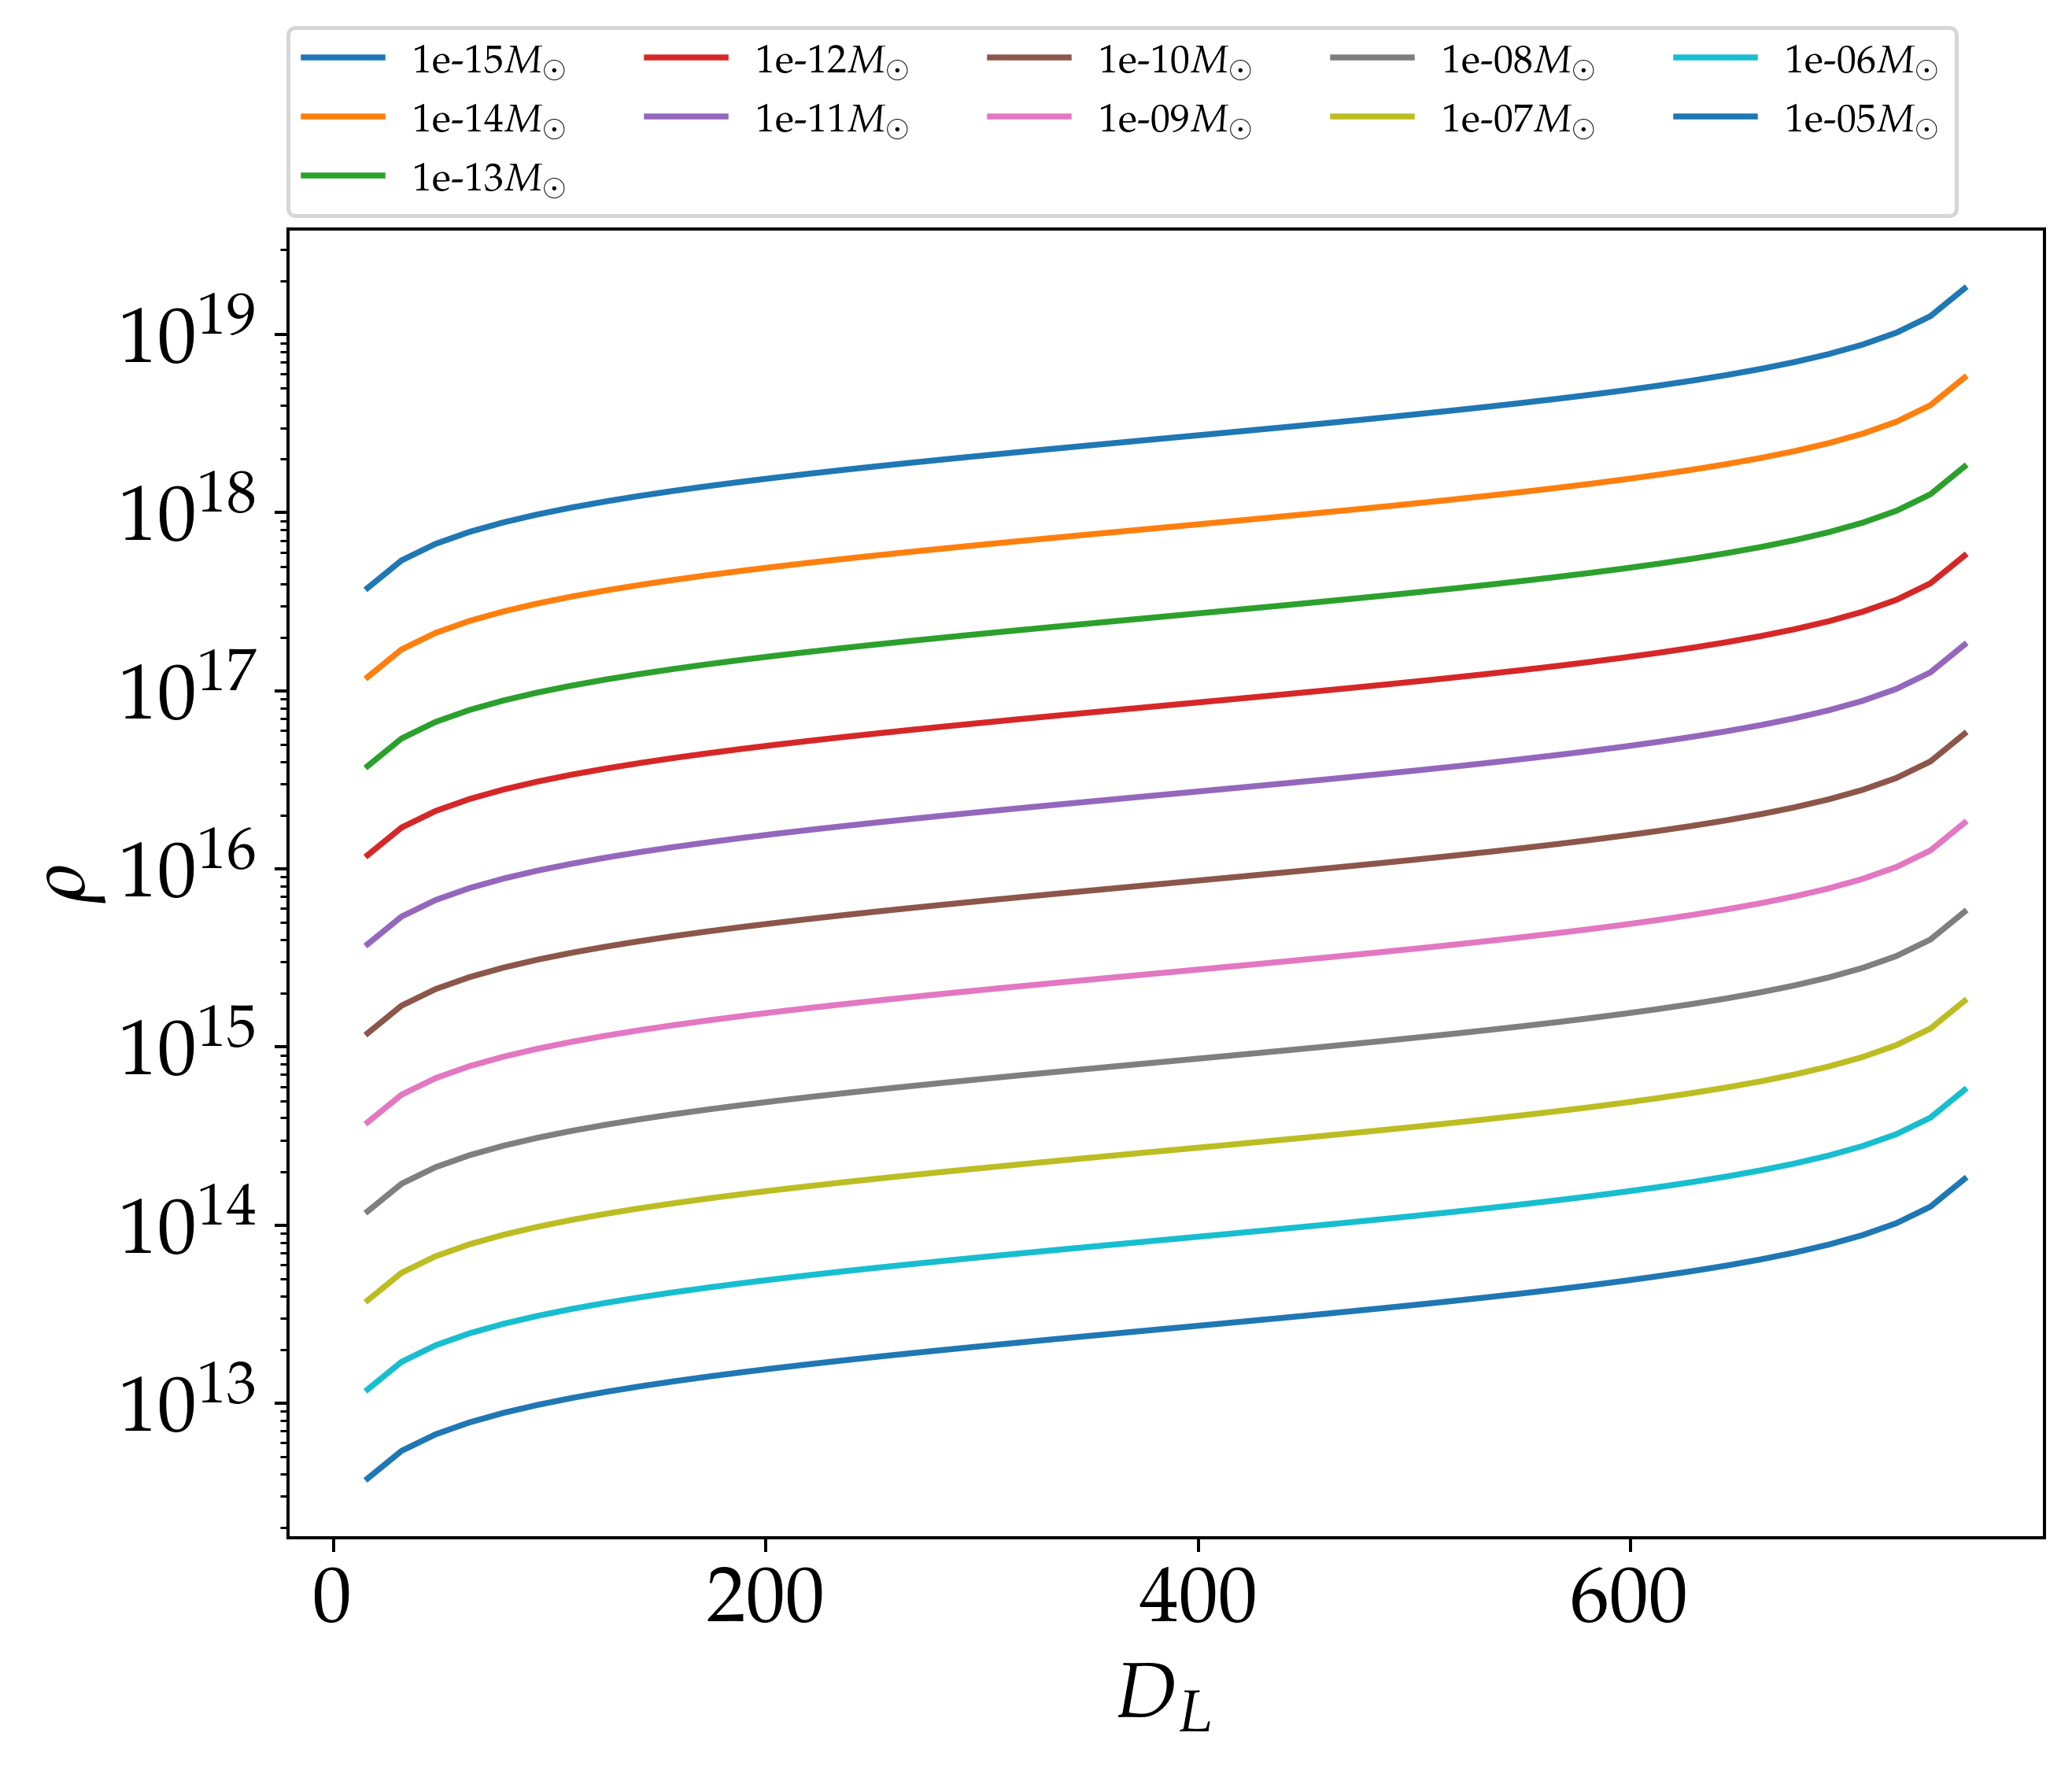

In [4]:
X = np.linspace(0,1)
plt.figure(figsize=(8,6),dpi=180)
for m in np.logspace(-15,-5,11):
    rhos = []
    for x in X:
        tE, rho = tE_rho(x,m)
        rhos.append(rho)
    plt.plot(X*770,rhos, label=str(m)+r"$M_{\odot}$")
plt.yscale('log')
plt.xlabel(r"$D_L$",fontsize=20)
plt.ylabel(r"$\rho$",fontsize=20)
plt.legend(loc=(0,1.01),ncols=5)
plt.show()

In [5]:
# M_sun = 1.988409870698051e+30 # M_sun in kg


# x = x_vals[3]
# m = 1e-10*M_sun
def uT_search(m, x):
    tE, rho = tE_rho(x,m)
    # print(tE, rho)
    # print(tE, rho)
    U0= np.linspace(0.01,3,100)
    
    t0 = 8550.4#, 100.3, 0.1  # Impact parameter, Time of closest approach, Einstein time, Source radius
    t = np.linspace(t0-5*tE, t0+5*tE,500)#t0+3*tE, 1000)  # Times at which we want to calculate the magnification
    A_max = []
    
    for u0 in U0:
        # Array of parameters
        pr = [math.log(u0),  # Note that we give some parameters in log scale
              math.log(tE),
              t0,
              math.log(rho)]
        # print(u0,tE,t0,rho)    
        VBM = VBMicrolensing.VBMicrolensing()
        VBM.SetLDprofile(VBM.LDquadratic)
        VBM.a1 = 0
        VBM.a2 = 0
        # VBM.a1 = 0.2  # Linear limb darkening coefficient.
        results = VBM.ESPLLightCurve(pr, t)  # Calculates the ESPL magnification at different times with parameters in pr
        A_max.append(max(results[0]))
    #     plt.plot(results[1], results[0],marker='.',label='Quadratic Limb Darkening')
    # plt.xlabel('u')
    # plt.ylabel(r'A')
    # plt.show()
    
    # plt.figure()
    # plt.plot(U0, A_max, '.' , ls='')
    # plt.axhline(1.34)
    # plt.yscale("log")
    # plt.show()
    amax = np.array(A_max)
    # print(U0[(1.34<amax)&(amax<1.345)])
    
    return find_intersection(np.array(U0), np.array(A_max), 1.34)

In [6]:
# X = np.linspace(1,150,1000)/770
m1 = 1e-10*M_sun
m2= 1e-11*M_sun
m3= 1e-12*M_sun
uT_1 = [-1]
uT_2 = [-1]
uT_3 = [-1]


In [30]:
from scipy.interpolate import interp1d
def interp(x_data,y_data):
    sorted_indices = np.argsort(x_data)
    x_data = x_data[sorted_indices]
    y_data = y_data[sorted_indices]

    #Agregar un punto artificial que decae a 0
    x_max = x_data[-1]
    delta = 0.001 * x_max  # un pequeño paso más allá
    arr1_extended = np.append(x_data, x_max + delta)
    arr0_extended = np.append(y_data, 0.0)
    
    # Interpolador cúbico o lineal (según prefieras)
    interp_func = interp1d(arr1_extended, arr0_extended, kind='cubic', bounds_error=False, fill_value=0.0)
    
    # Interpolación
    if x_max + delta>1:
        limlogmax = 0
    else:
        limlogmax = np.log10(x_max + delta)
    x_interp = np.logspace(np.log10(x_data[0]), limlogmax , 1000)
    y_interp = interp_func(x_interp)
    return x_interp, y_interp


In [73]:
from tqdm import tqdm
import numpy as np
ut_curves ={}

for mass in tqdm([1e-6,1e-7,1e-8,1e-9, 1e-10, 1e-11,1e-12,1e-13]): 
    uT_0 = [] 
    min_exp = -9  
    # mass = 1e-3 
    m4 = mass * M_sun 
    
    for xf in np.logspace(-9,0,2000):   
        tE, rho = tE_rho(xf,m4)  
        if rho>99: 
            # print(xf) 
            break 
    # print(np.log10(xf)) 
    
    if np.log10(xf)>-0.0090: 
        X = np.logspace(min_exp, -0.0090, 2000)# / 770    

    else: 
        X = np.logspace(min_exp, np.log10(xf), 2000)# / 770
        
    for i, x in enumerate(X):
        # print(x)
        new_uT = uT_search(m4, x)
        # Stop if the new value is too small
        if new_uT < 0:
            # print(f"Stopped at index {i}, x = {x:.3e}")
            break
    
        uT_0.append(new_uT)

    if i<1999:
        x, uT = interp(X[:i],np.array(uT_0))
    else:
        x, uT = interp(X,np.array(uT_0))
        
    # if mass>1e-9:
    #     ut_curves[str(mass)] = [X,np.array(uT_0)]
    # else:
    ut_curves[str(mass)] = [x, uT]
    
    # if i == 999:
    #     np.savez('/home/anibal-pc/figures_final_makler/u_t_baja_precision/uT_1e-'+str(np.log10(mass))+'_NOT_LD', uT_0, X*770)
    # else:
    #     np.savez('/home/anibal-pc/figures_final_makler/u_t_baja_precision/uT_1e-'+str(np.log10(mass))+'_NOT_LD', uT_0, X[:i]*770)


  0%|                                                     | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_22835/1823033876.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  rho = R_star*x/(rE) #1Rsun
100%|█████████████████████████████████████████████| 8/8 [01:20<00:00, 10.10s/it]


<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_22835/3254224733.py:8: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(ut_curves[key][0]*770,ut_curves[key][1],lw=3,label=r'$M_{PBH}='+str(key)+'M_{\odot}$')


2
2
2


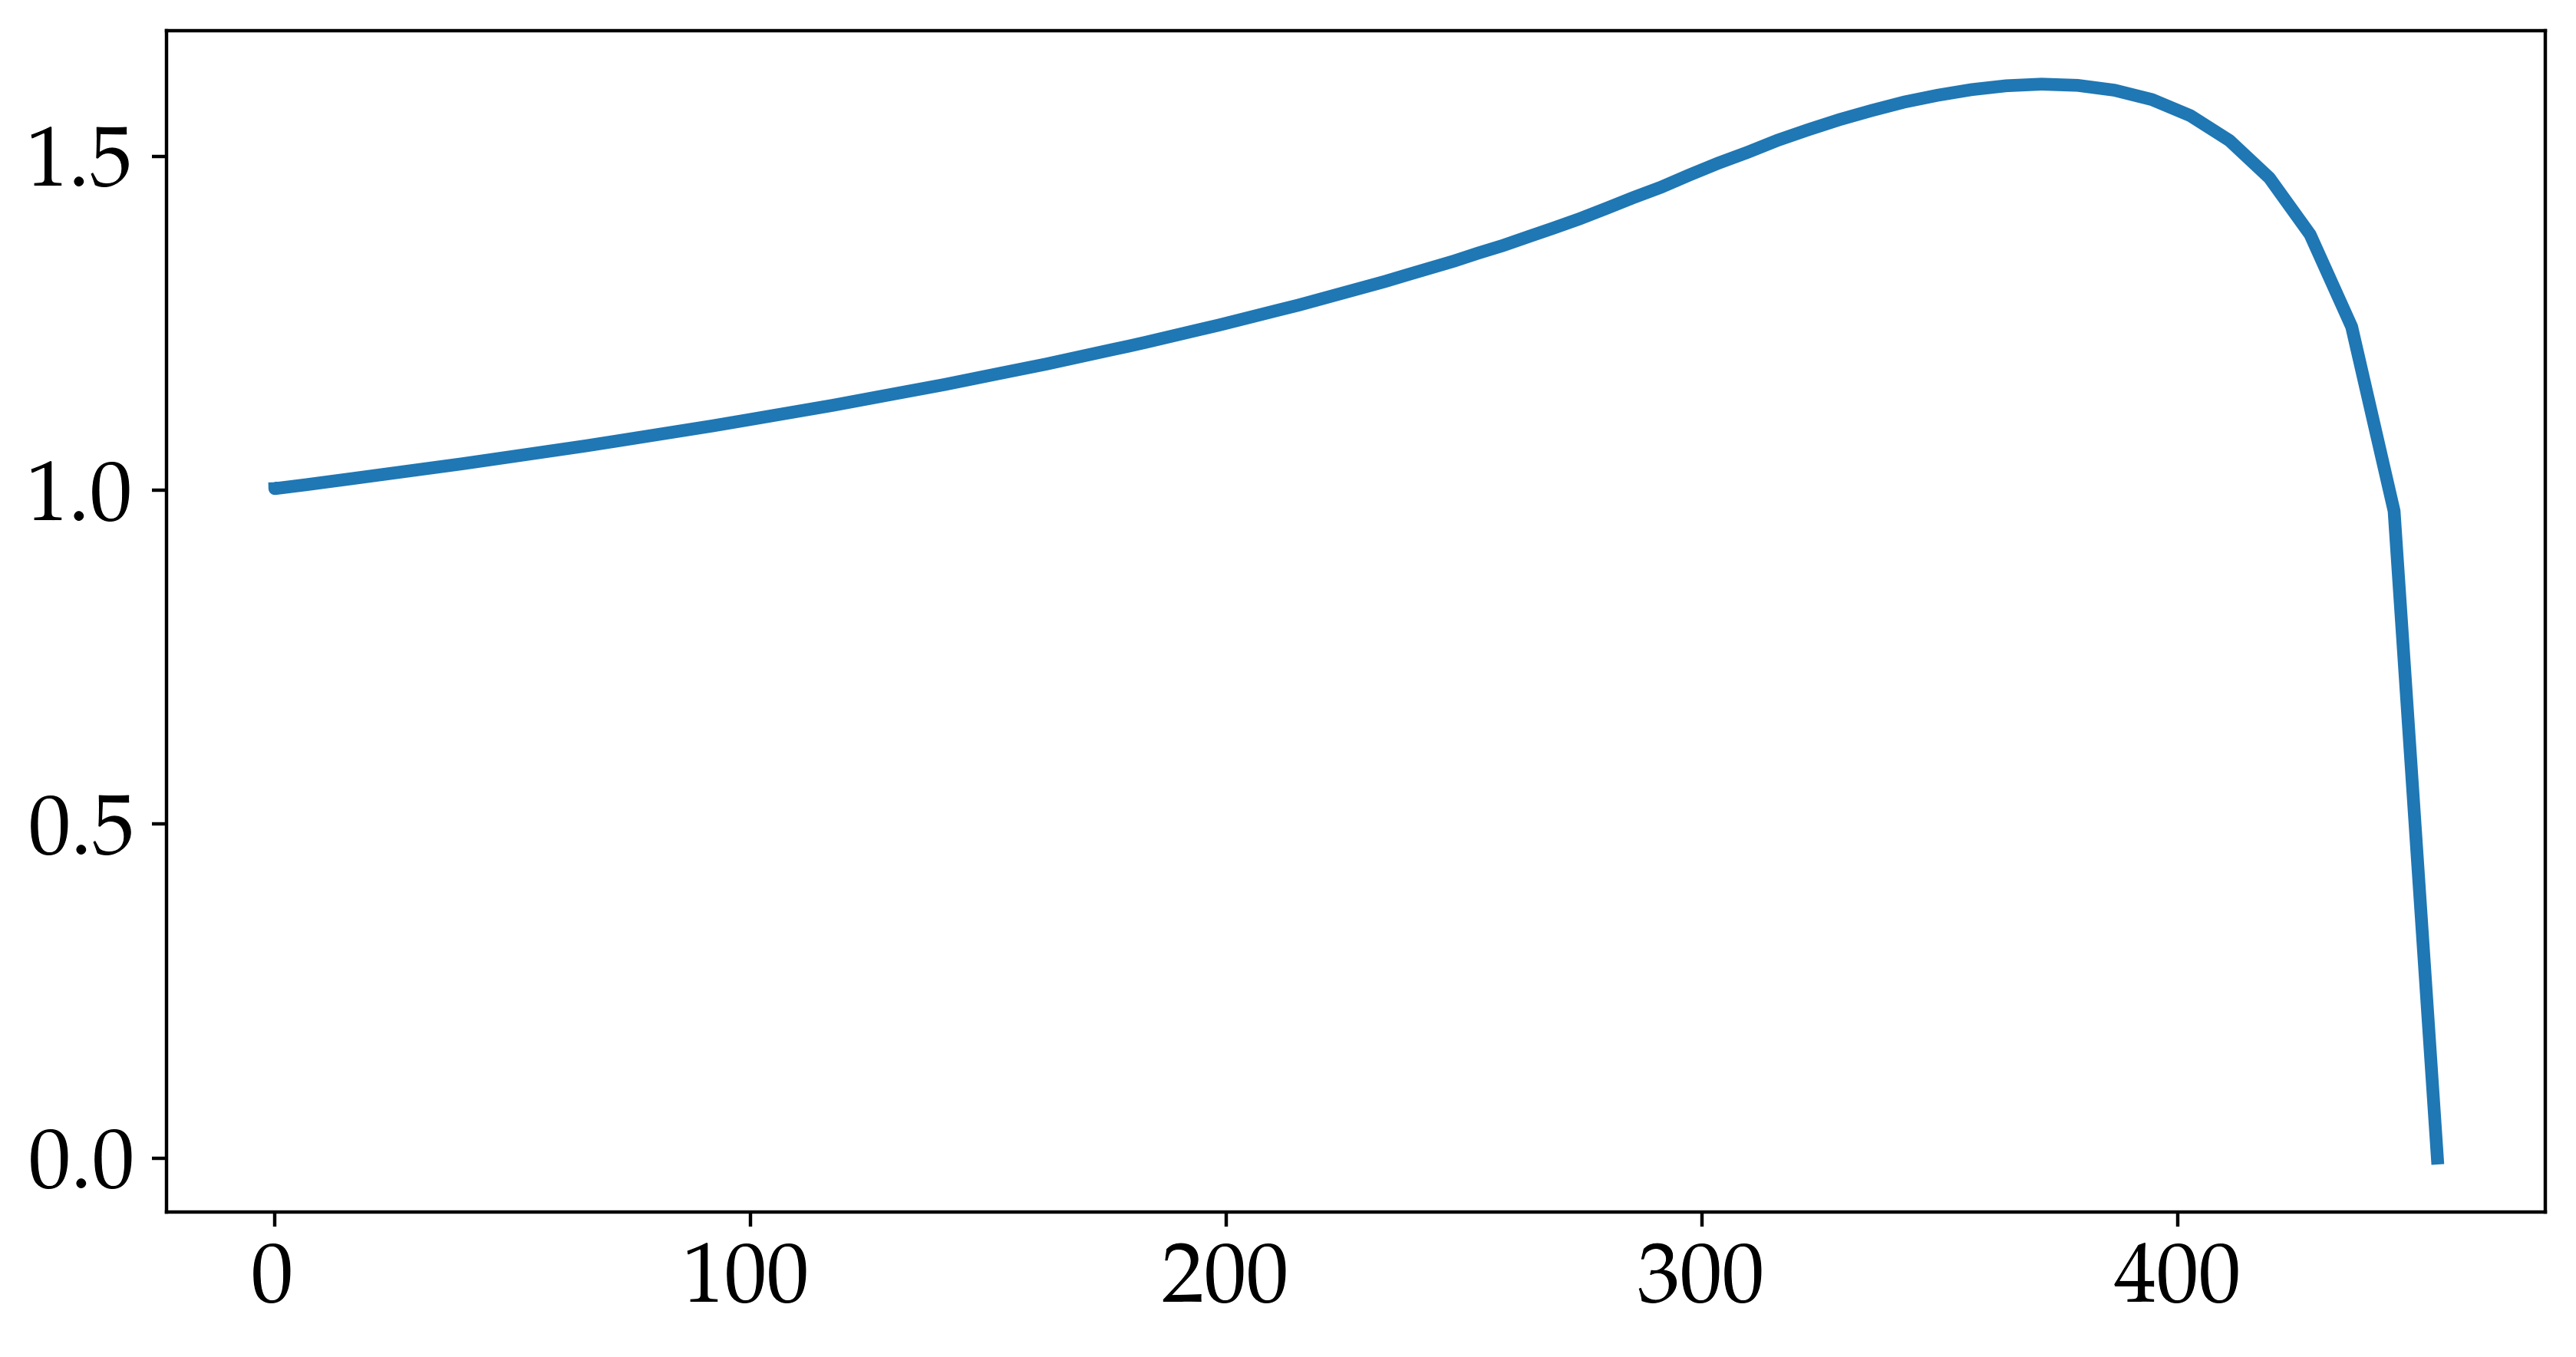

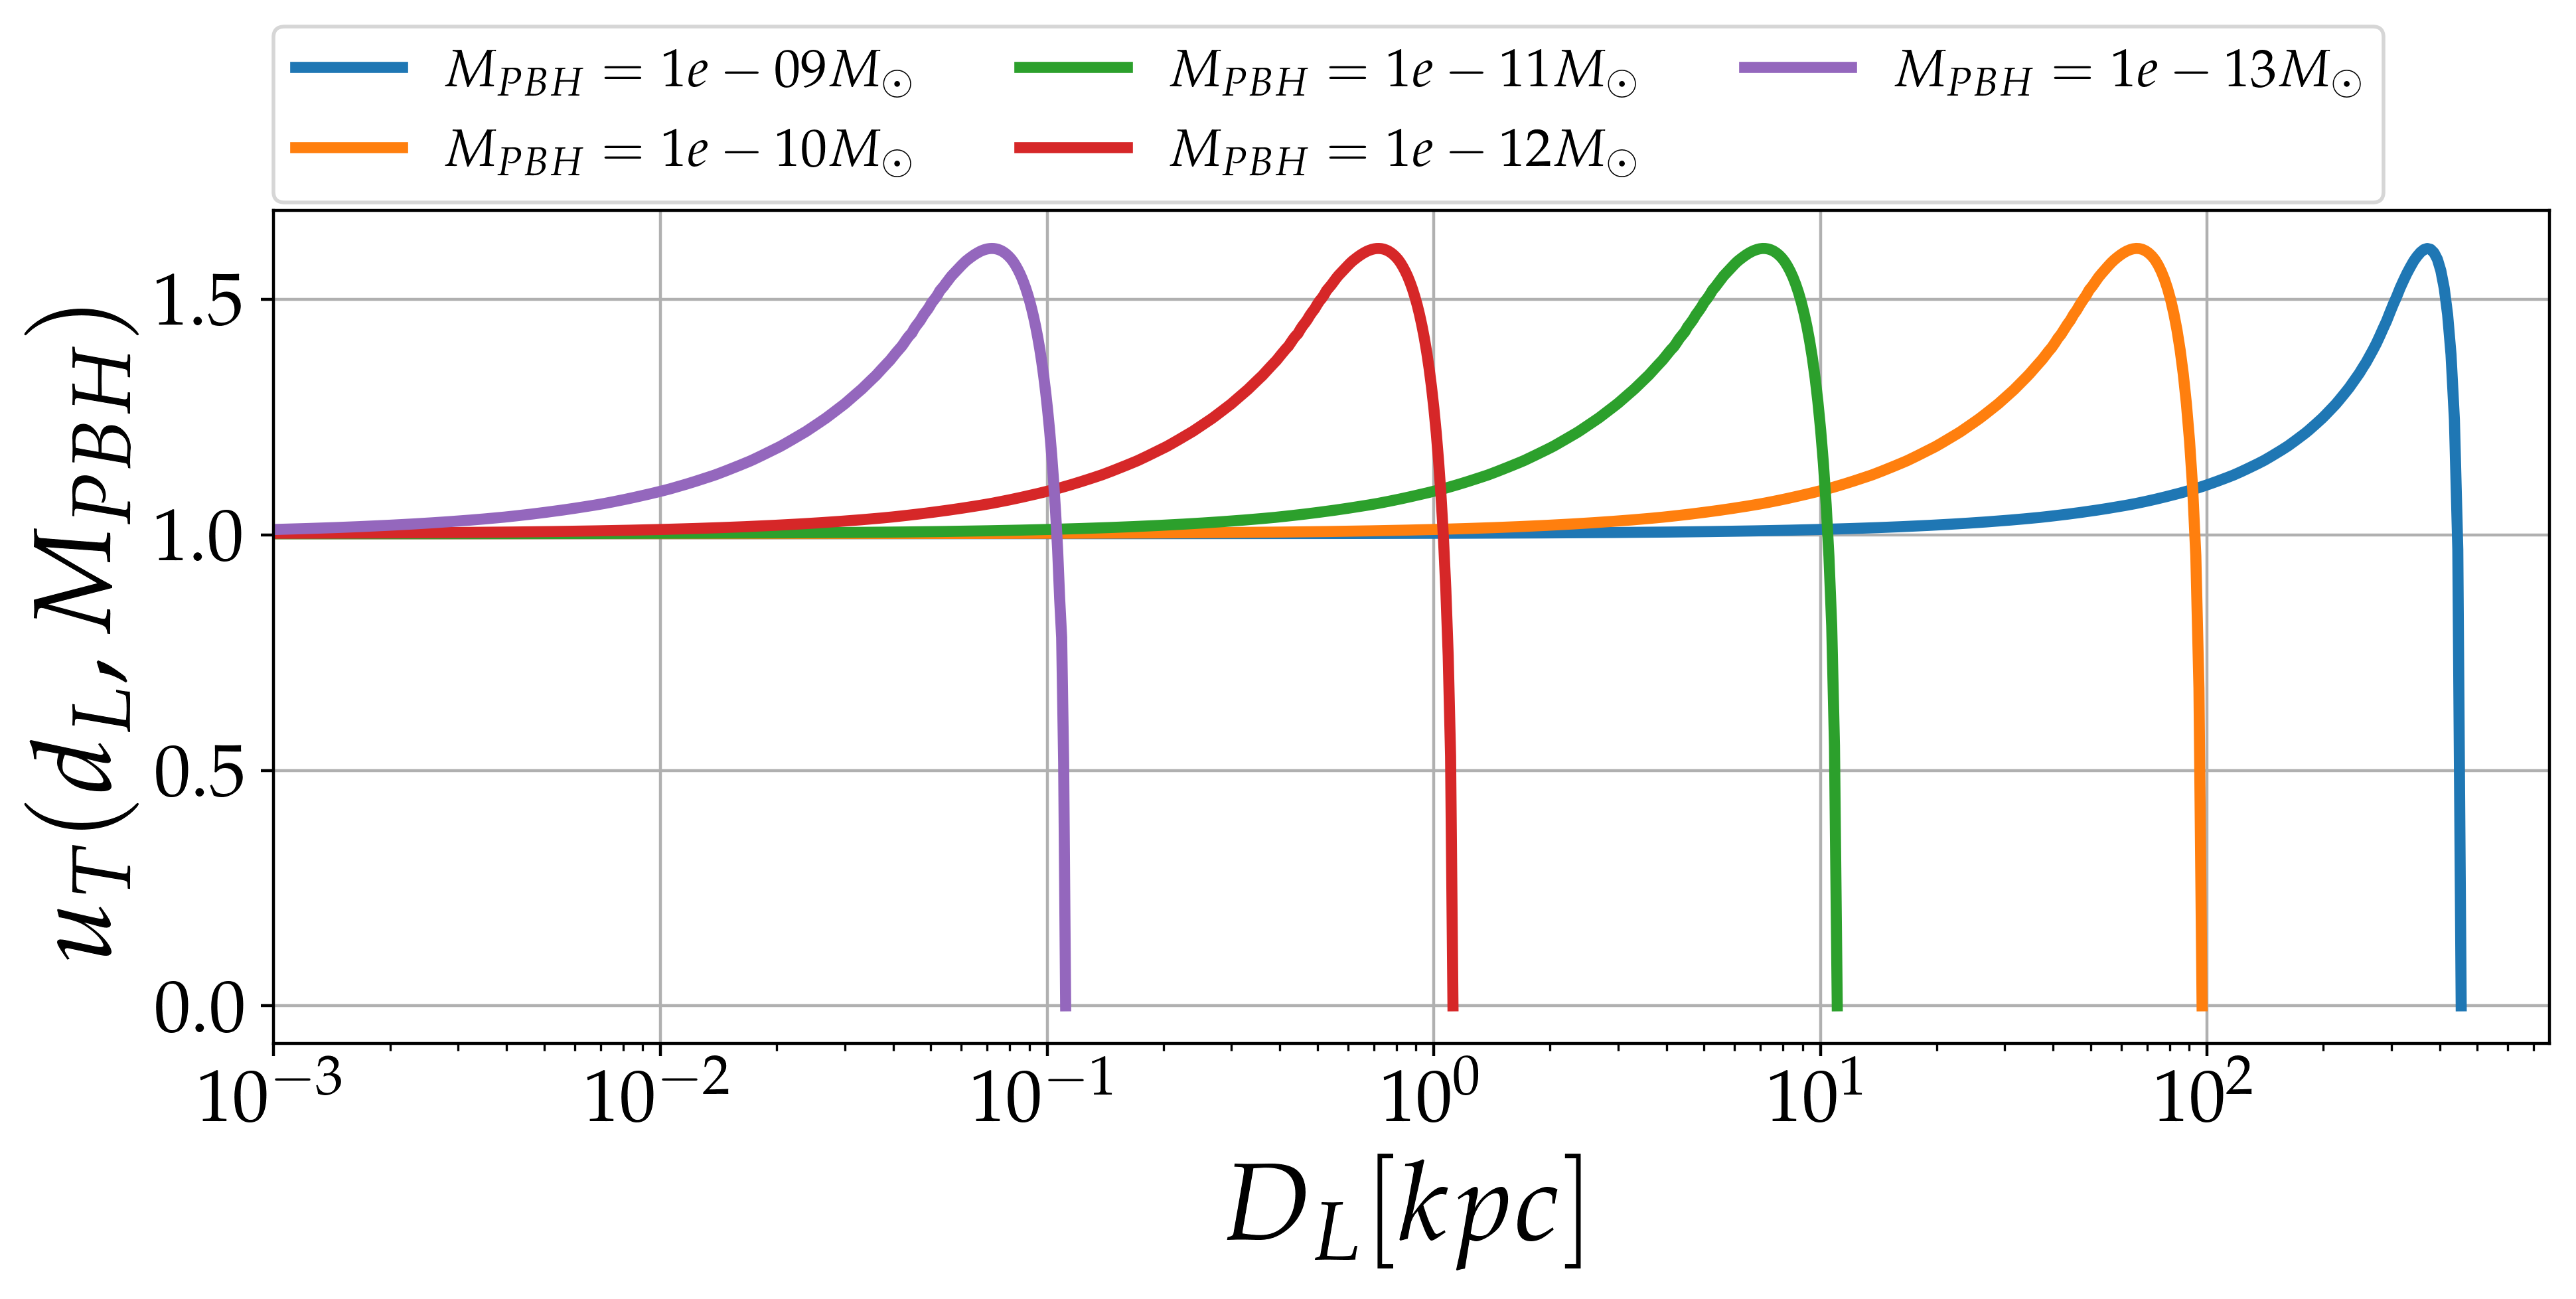

In [74]:
plt.figure(figsize=(10,5),dpi=200)
for key in ut_curves:
    plt.plot(ut_curves[key][0]*770,ut_curves[key][1],lw=3,label=r'$M_{PBH}='+str(key)+'M_{\odot}$')
plt.xlabel(r"$D_L [kpc]$", fontsize=30)
plt.ylabel(r"$u_T(d_L, M_{PBH})$", fontsize=30)
plt.xscale("log")
plt.grid(True)
plt.xlim(1e-3,770)
plt.legend(loc=(0,1.01),fontsize=14.5,ncols=3)
plt.tight_layout()
plt.savefig('/home/anibal-pc/figures_final_makler/u_T.png')
plt.show()


<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_22835/1351316755.py:2: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(ut_curves['1e-06'][0]*770,ut_curves['1e-06'][1],lw=3,label=r'$M_{PBH}='+str(mass)+'M_{\odot}$')


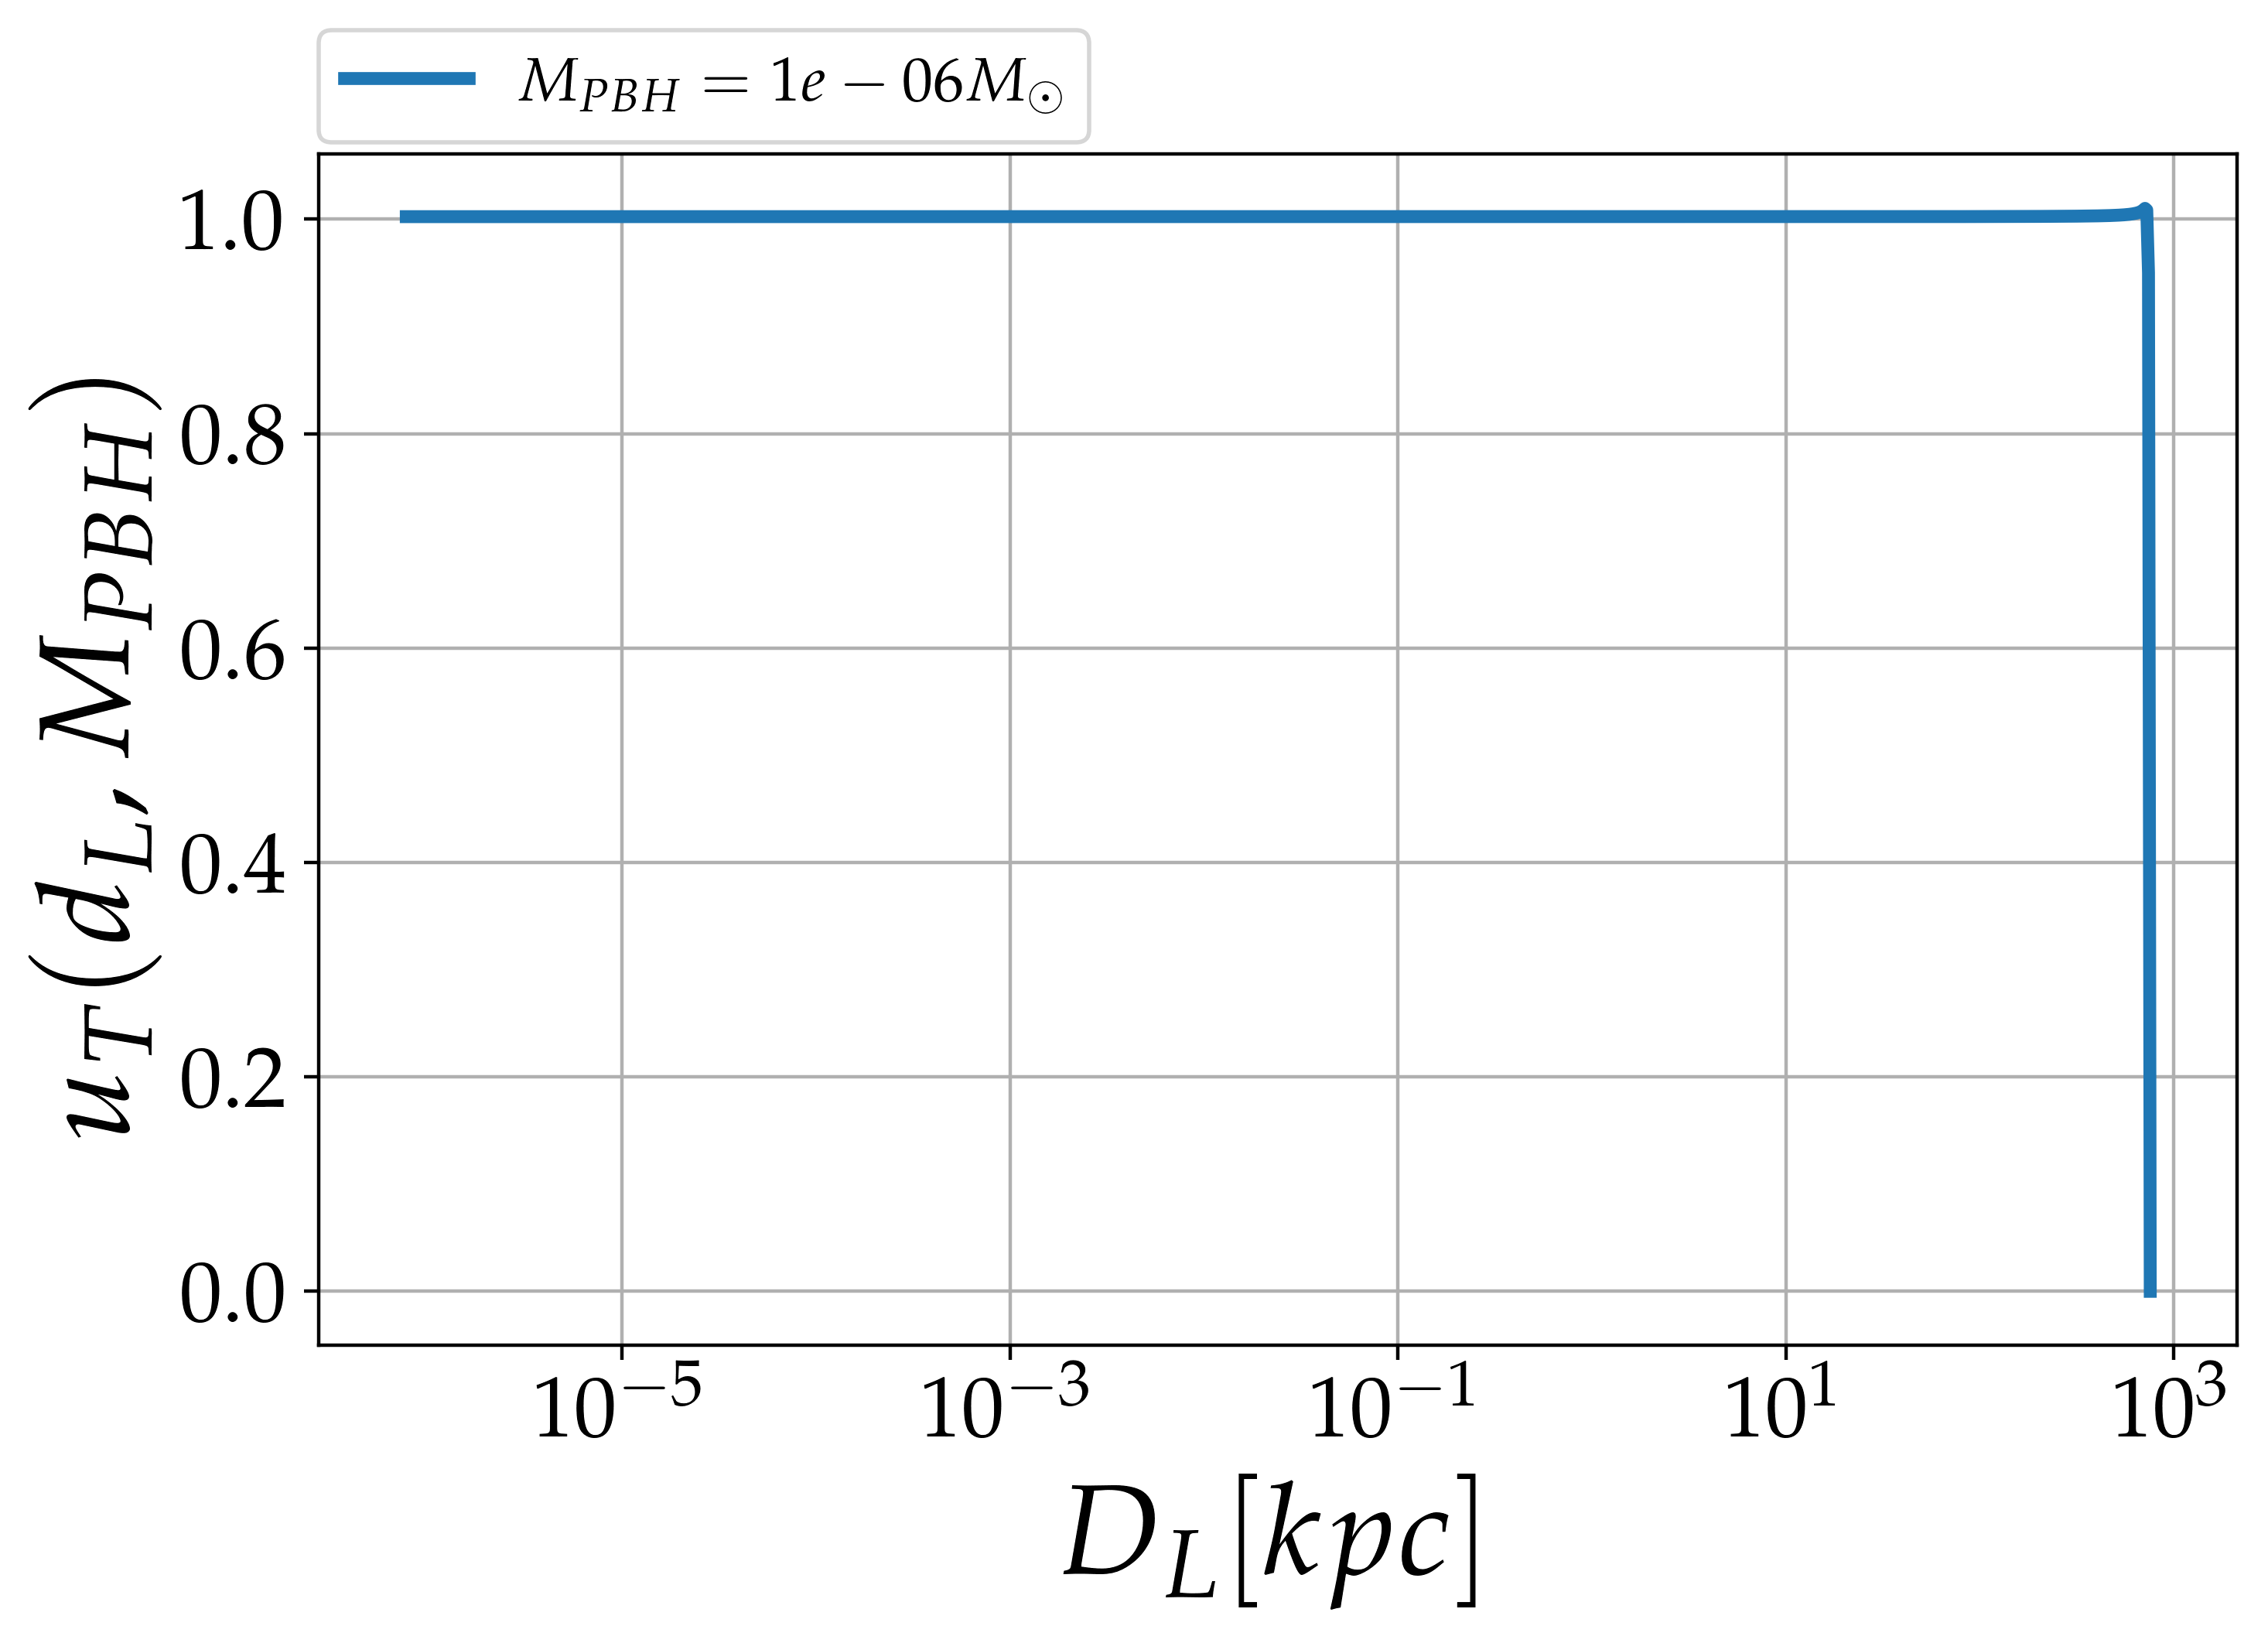

In [39]:
plt.figure(figsize=(8,5),dpi=200)
plt.plot(ut_curves['1e-06'][0]*770,ut_curves['1e-06'][1],lw=3,label=r'$M_{PBH}='+str(mass)+'M_{\odot}$')
# plt.plot(X*770,uT_1,lw=3,label=r'$M_{PBH}=10^{-11}M_{\odot}$')
# plt.plot(X*770,uT_2,lw=3,label=r'$M_{PBH}=10^{-12}M_{\odot}$')
# plt.plot(X*770,uT_3,lw=3,label=r'$M_{PBH}=10^{-15}M_{\odot}$')
# plt.ylim(0,2)
# plt.xticks([10,100,300,770],[10,100,300,770])
plt.xlabel(r"$D_L [kpc]$", fontsize=30)
plt.ylabel(r"$u_T(d_L, M_{PBH})$", fontsize=30)
plt.xscale("log")
plt.grid(True)
plt.legend(loc=(0,1.01),fontsize=14.5,ncols=2)
plt.savefig('/home/anibal-pc/figures_final_makler/u_T.png')
plt.show()


In [45]:
string = os.listdir('/home/anibal-pc/figures_final_makler/uT_curves/')[i]
ini = string.index('1e-')+3
fin = string.index('_NOT')
10**float(string[ini:fin])

7.3907220335257755e-09

In [13]:
import os
import numpy as np

mass_logarg = 10**-13


for i in range(0,100): 
    string = os.listdir('/home/anibal-pc/figures_final_makler/uT_curves/')[i]
    ini = string.index('1e-')+3
    fin = string.index('_NOT')
    # print(float(string[ini:fin]))
    if mass_logarg-1<10**float(string[ini:fin])<mass_logarg:
        arr0 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/'+string)['arr_0']
        arr1 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/'+string)['arr_1']
        print(i)
        print(string)
        # break

0
uT_1e--14.191919191919192_NOT_LD.npz
2
uT_1e--14.8989898989899_NOT_LD.npz
8
uT_1e--13.080808080808081_NOT_LD.npz
11
uT_1e--14.595959595959595_NOT_LD.npz
16
uT_1e--14.090909090909092_NOT_LD.npz
18
uT_1e--14.393939393939394_NOT_LD.npz
22
uT_1e--13.282828282828284_NOT_LD.npz
24
uT_1e--15.0_NOT_LD.npz
37
uT_1e--13.383838383838384_NOT_LD.npz
39
uT_1e--13.585858585858587_NOT_LD.npz
40
uT_1e--14.292929292929292_NOT_LD.npz
41
uT_1e--14.797979797979798_NOT_LD.npz
50
uT_1e--13.484848484848484_NOT_LD.npz
53
uT_1e--13.98989898989899_NOT_LD.npz
61
uT_1e--13.88888888888889_NOT_LD.npz
62
uT_1e--14.494949494949495_NOT_LD.npz
66
uT_1e--13.686868686868687_NOT_LD.npz
72
uT_1e--13.787878787878787_NOT_LD.npz
90
uT_1e--14.696969696969697_NOT_LD.npz
95
uT_1e--13.181818181818182_NOT_LD.npz


In [14]:

num = 10**-13.080808080808#10**float(string[ini:fin-1])
def rounder(num):
    print(num)
    logarg = np.log10(abs(num))
    print(logarg)
    return round(num,int(abs(logarg))+1)
    
print(rounder(num))
# print(10**float(string[ini:fin-1]))
# round(10**float(string[ini:fin-1]),rounder)

8.302175681321297e-14
-13.080808080808
8e-14


<>:14: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:14: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_22835/283114710.py:14: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(arr1,arr0,label = str(mass_label)+'$M_{\odot}$')
/tmp/ipykernel_22835/283114710.py:17: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(arr1,arr0[:len(arr1)],label = str(mass_label)+'$M_{\odot}$')
/tmp/ipykernel_22835/283114710.py:28: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,1*770)


3.853528593710567e-07
-6.41414141414141
here
1.0023969570943414
4.43062145758443e-11
-10.3535353535353
0.31800451318575174
8.302175681321297e-14
-13.080808080808
0.32726459909436756
6.428073117285686e-15
-14.1919191919191
0.41770251319343976
1.2618568830660185e-15
-14.8989898989899
0.3042754250930651
6.89261210444748e-12
-11.16161616161
0.30039721702980615


<Figure size 1600x1000 with 0 Axes>

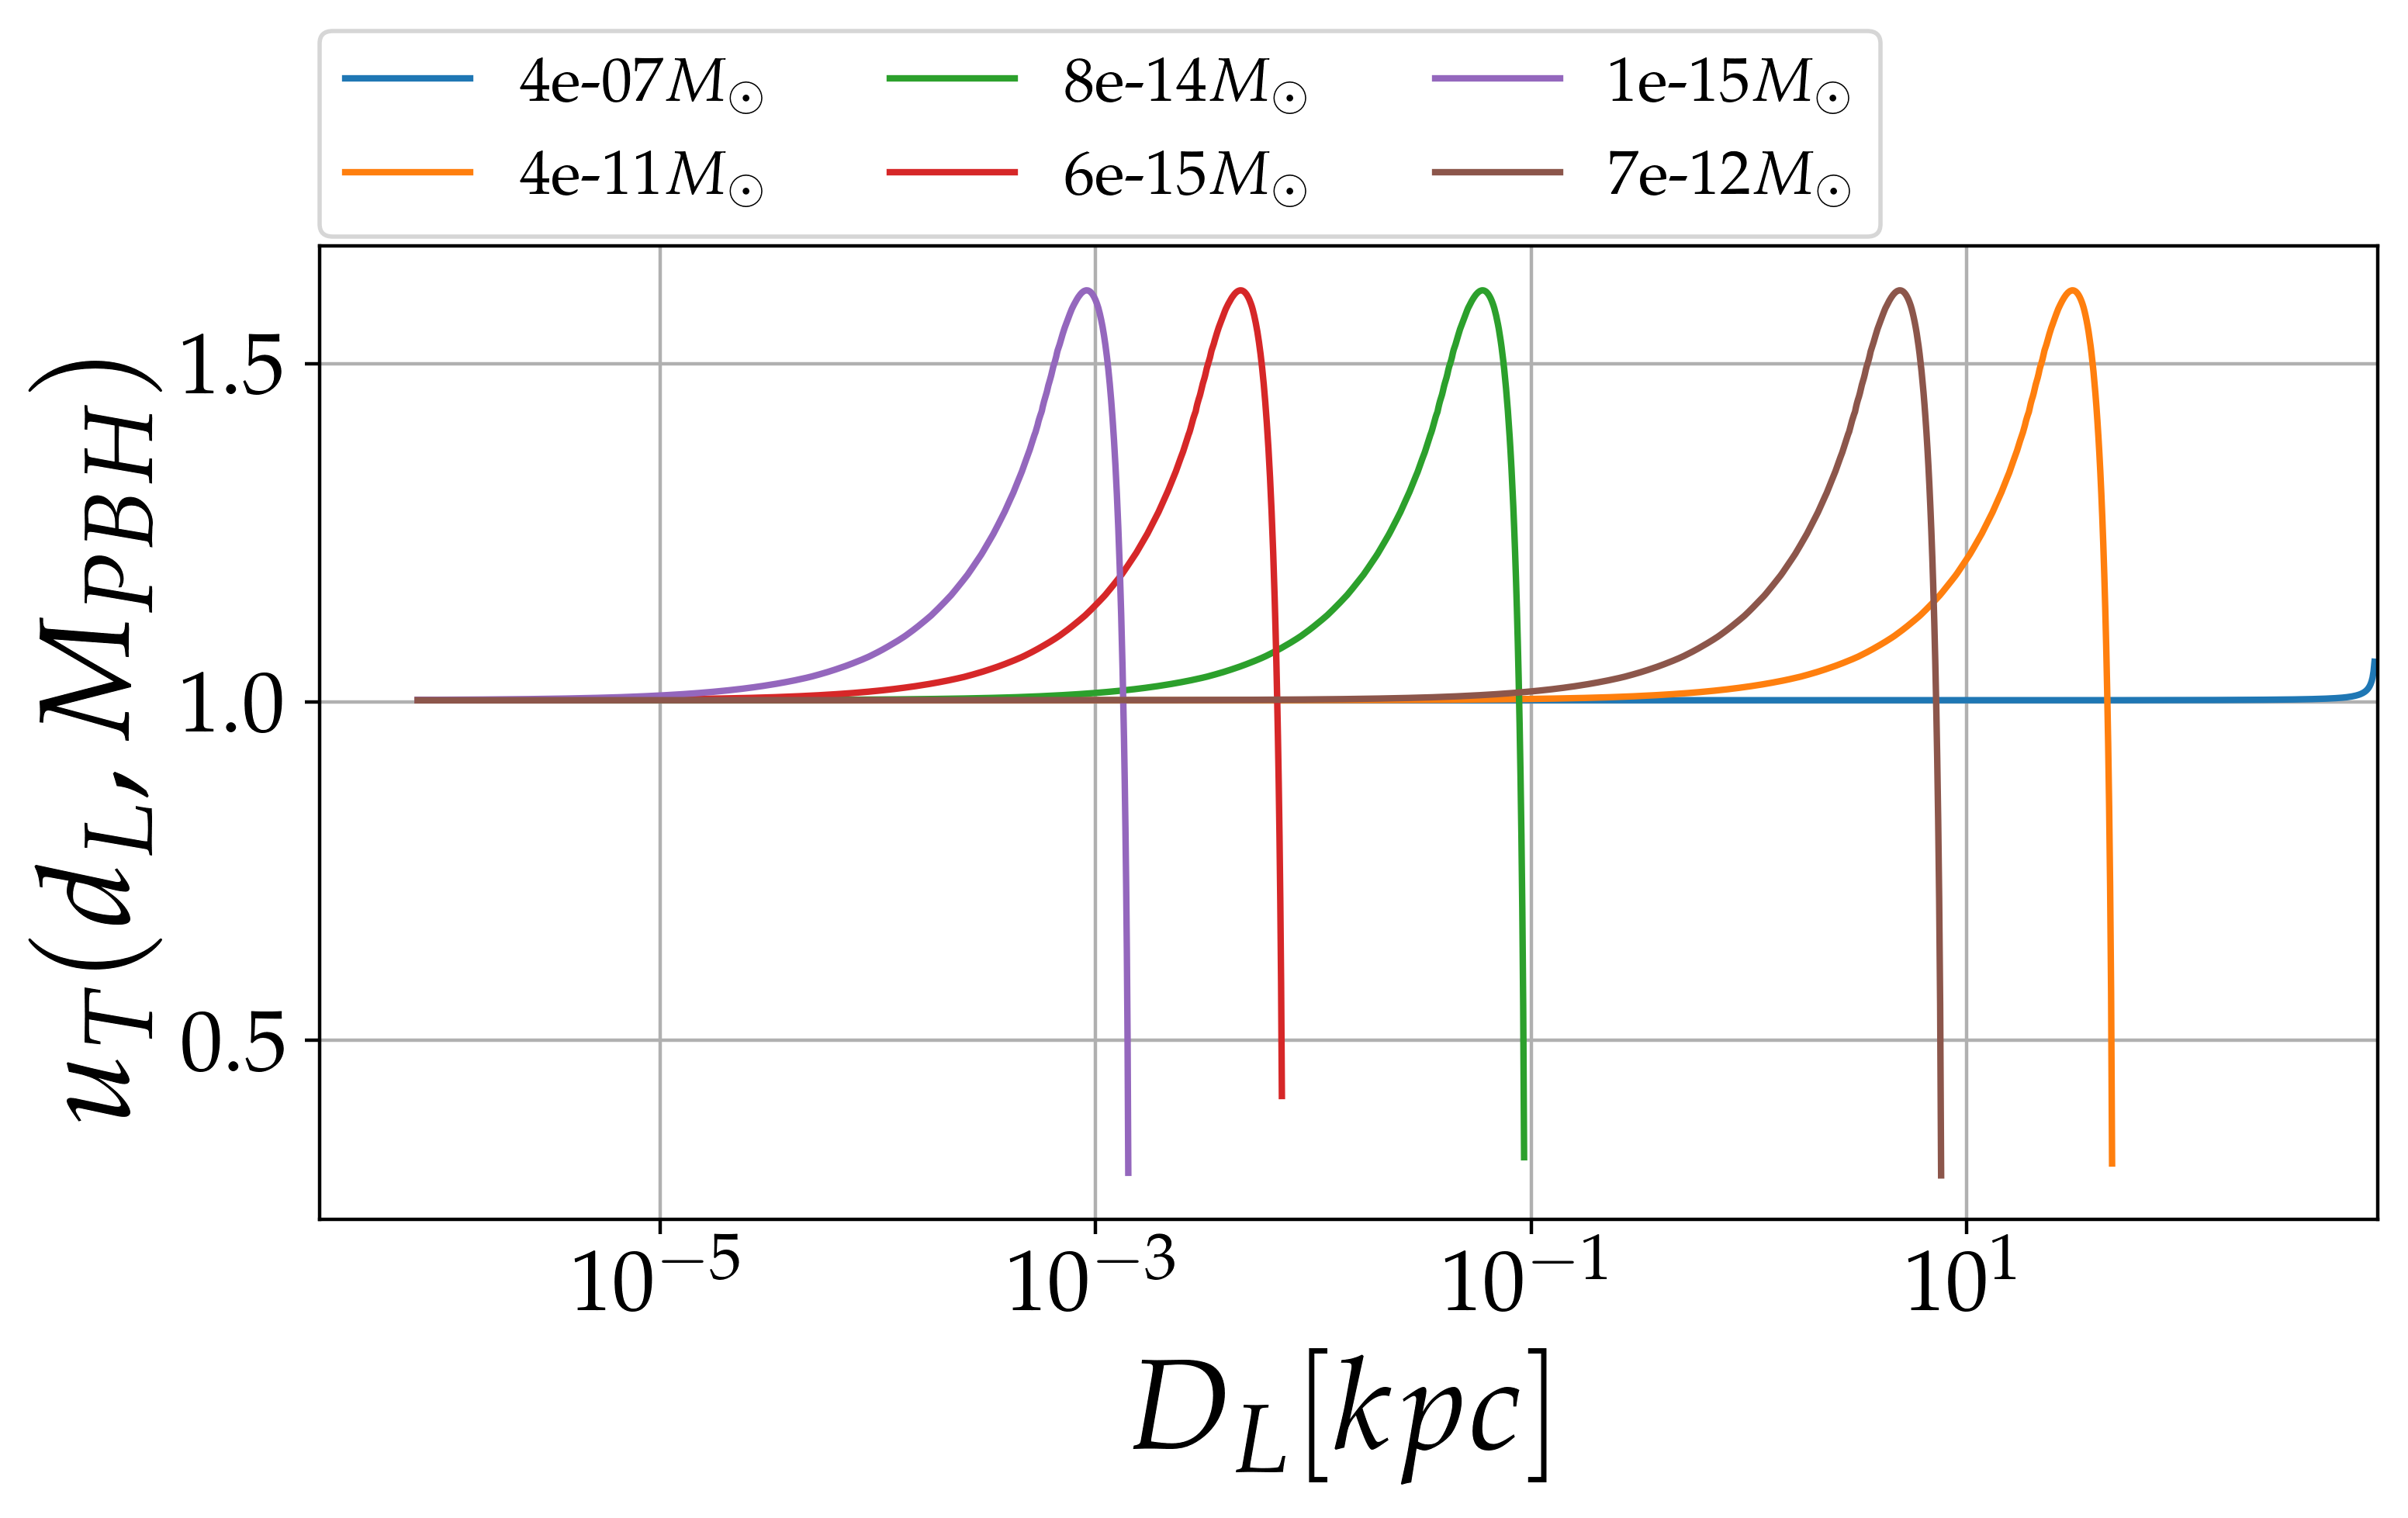

In [15]:
import os 
arr = [] 
plt.figure(figsize=(8,5),dpi=200)
# 10,
for i in [3,4,8,0,2,17]: 
    string = os.listdir('/home/anibal-pc/figures_final_makler/uT_curves/')[i]
    arr0 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/'+string)['arr_0']
    arr1 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/'+string)['arr_1']
    
    # print(len(arr1),len(arr0))
    mass = 10**float(string[ini:fin-2])
    mass_label = rounder(mass)
    if len(arr1)==len(arr0):
        plt.plot(arr1,arr0,label = str(mass_label)+'$M_{\odot}$')
    elif not len(arr1)==len(arr0):
        print('here')
        plt.plot(arr1,arr0[:len(arr1)],label = str(mass_label)+'$M_{\odot}$')
    print(min(arr0))
    plt.xscale("log")
    ini = string.index('1e-')+3
    fin = string.index('_NOT')
    # arr.append(10**float(string[ini:fin]))
# plt.legend(loc='best')

plt.xlabel(r"$D_L [kpc]$", fontsize=30)
plt.ylabel(r"$u_T(d_L, M_{PBH})$", fontsize=30)
plt.xscale("log")
plt.xlim(0,1*770)
plt.grid(True)
plt.legend(loc=(0,1.01),fontsize=14.5,ncols=3)
plt.tight_layout()
plt.savefig('/home/anibal-pc/figures_final_makler/u_T.png')
plt.show()
# print(np.sort(np.array(arr))==np.logspace(-15,5,100))

In [27]:
# arr0 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/uT_1e--14.0_NOT_LD.npz')['arr_0']
# arr1 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/uT_1e--14.0_NOT_LD.npz')['arr_1']
# plt.plot(arr1,arr0[0:558])
# plt.xscale("log")

# arr0 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/uT_1e--15.0_NOT_LD.npz')['arr_0']
# arr1 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/uT_1e--15.0_NOT_LD.npz')['arr_1']

# plt.plot(arr1,arr0[:489])
# plt.xscale("log")
# plt.show()

$$I(\nu) = I(0) \left[1 - a1 (1 - \nu)- a2 (1-\nu)^2 \right]$$


In [28]:
# arr1

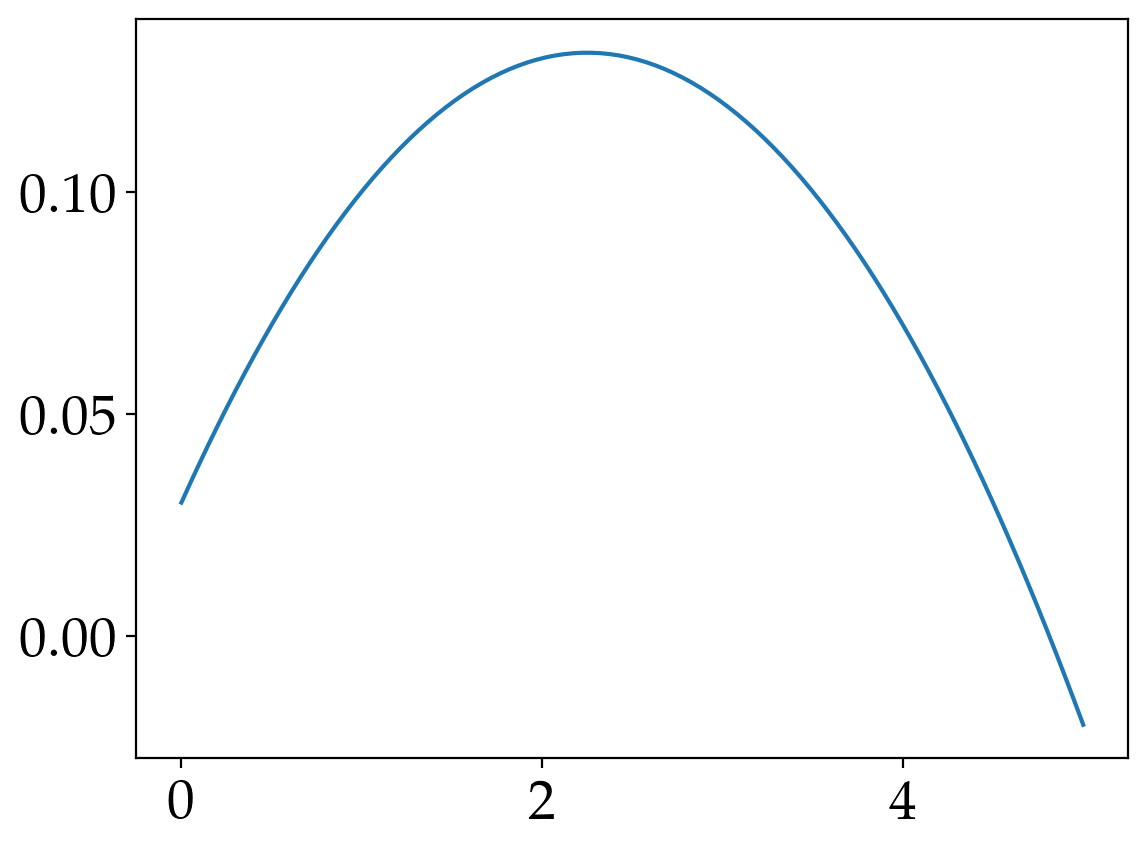

In [157]:
#profile Limb darkening

# $$I(\nu) = I(0) \left[1 - a1 (1 - \nu)- a2 (1-\nu)^2 \right]$$
a1 = 0.5
a2 = 0.2
I0=0.1
I = lambda nu: I0*(1-a1*(1-nu)-a2*(1-nu)**2)
nu=np.linspace(0,5,100)
plt.plot(nu, I(nu))
plt.show()